# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking-balanced/notebooks'

In [2]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, 
                      draw_sample_xy, draw_sample_rphi, draw_sample_rz)

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['font.size'] = 14

## Load training results

Specify which results to load either by config file or training output directory.

In [5]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/heptrkx/results_balanced')

In [6]:
ls $result_base

agnn_001/          scaling_agnn_n4/         scaling_cgpu_agnn_n2/
mpnn_001/          scaling_agnn_n64/        scaling_cgpu_agnn_n32/
scaling_agnn_n1/   scaling_agnn_n8/         scaling_cgpu_agnn_n4/
scaling_agnn_n16/  scaling_cgpu_agnn_n1/    scaling_cgpu_agnn_n64/
scaling_agnn_n2/   scaling_cgpu_agnn_n128/  scaling_cgpu_agnn_n8/
scaling_agnn_n32/  scaling_cgpu_agnn_n16/


In [7]:
result_name = 'mpnn_001'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'balanced_sampler': True,
          'batch_size': 1,
          'data_buckets': 128,
          'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_high_002',
          'n_train': 57344,
          'n_valid': 4096,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_edge_layers': 4,
           'n_graph_iters': 8,
           'n_node_layers': 4,
           'name': 'mpnn'},
 'n_ranks': 32,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 64,
                                      'factor': 0.1,
                                      'start_epoch': 32}],
               'name': 'Adam',
               'weight_decay': 1e-05},
 'output_dir': '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/mpnn_001',
 'trainer': {'name': 'gnn_sparse

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.0010,0.390212,3466.619882,27.480350,0,154.695809,0.177998,0.920131,2.223536
1,0.0010,0.236008,3594.221146,28.211184,1,153.153188,0.140602,0.940050,2.218622
2,0.0010,0.200640,3745.600651,29.079146,2,153.225021,0.107314,0.955778,2.981200
3,0.0010,0.156457,3851.785376,29.856639,3,153.530533,0.086207,0.965297,2.236179
4,0.0010,0.134041,3922.799509,30.419047,4,153.498768,0.077868,0.968960,2.216990
...,...,...,...,...,...,...,...,...,...
59,0.0001,0.053315,4564.978648,37.722854,59,153.916069,0.028750,0.991142,2.230797
60,0.0001,0.052743,4561.407654,37.699934,60,153.807599,0.031576,0.990353,2.219883
61,0.0001,0.052632,4557.221207,37.675225,61,153.536819,0.031141,0.990449,2.221603
62,0.0001,0.052089,4553.131689,37.651908,62,153.472562,0.029428,0.990972,2.759230


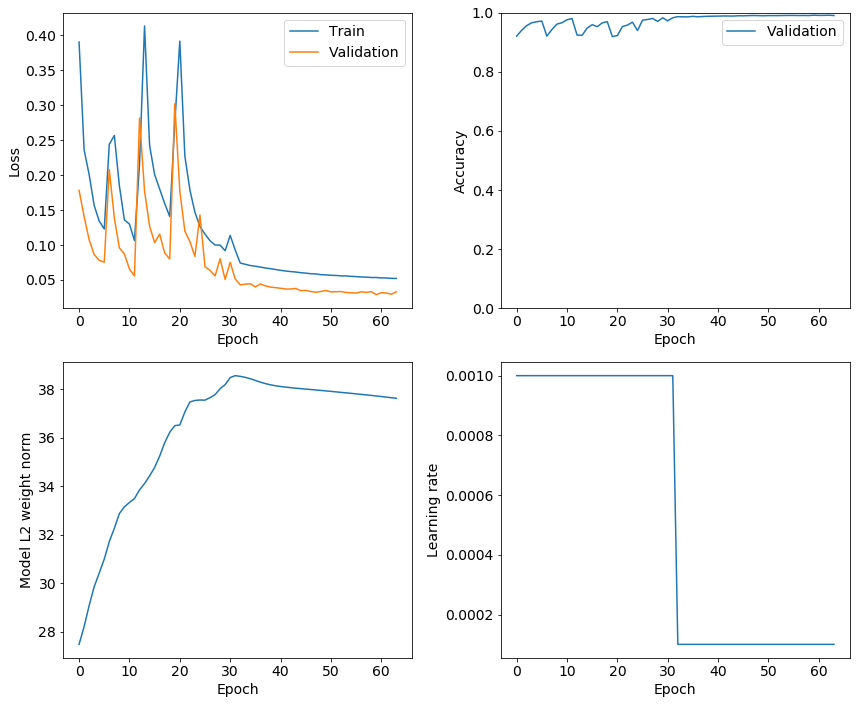

In [8]:
plot_train_history(summaries)

## Load the trained model

In [9]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
59,0.0001,0.053315,4564.978648,37.722854,59,153.916069,0.02875,0.991142,2.230797


In [10]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bia

## Load the test data set and evaluate the model

In [11]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [12]:
%%time
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 2min 32s, sys: 5.44 s, total: 2min 37s
Wall time: 39.4 s


In [13]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.5
Accuracy:  0.9912
Precision: 0.9375
Recall:    0.9400
F1 score:  0.9388


In [14]:
threshold = 0.7
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.7
Accuracy:  0.9919
Precision: 0.9652
Recall:    0.9205
F1 score:  0.9423


In [15]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.8
Accuracy:  0.9916
Precision: 0.9774
Recall:    0.9037
F1 score:  0.9391


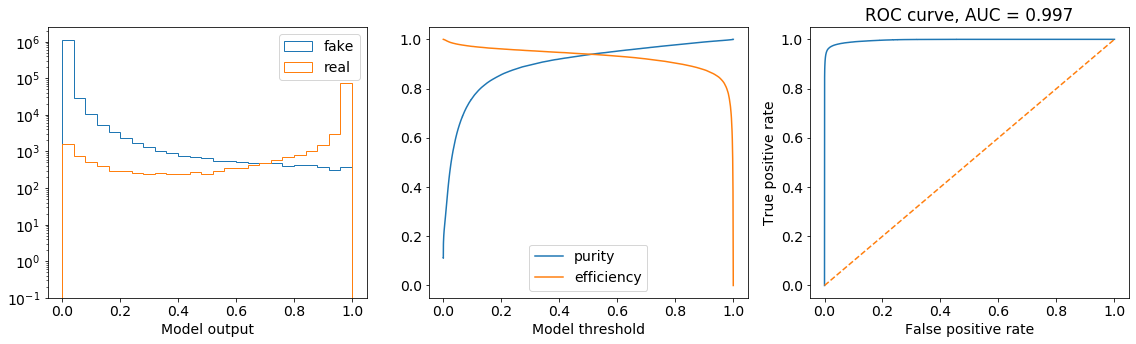

In [16]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [17]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [18]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

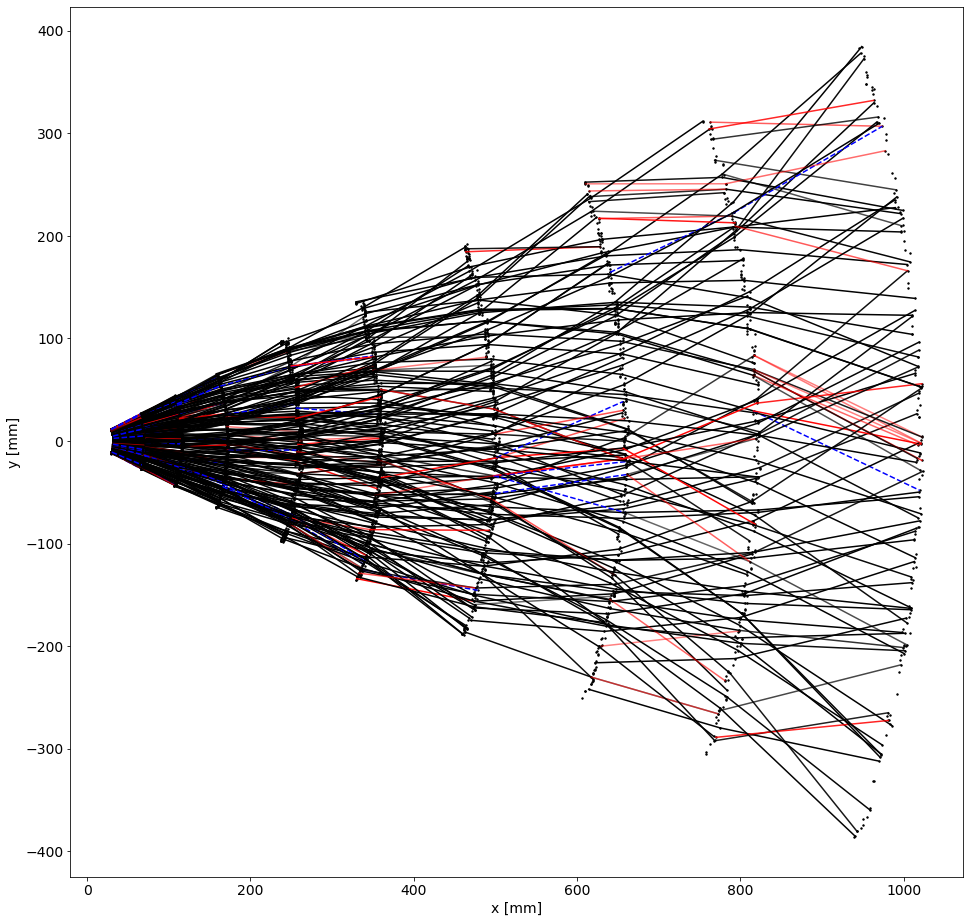

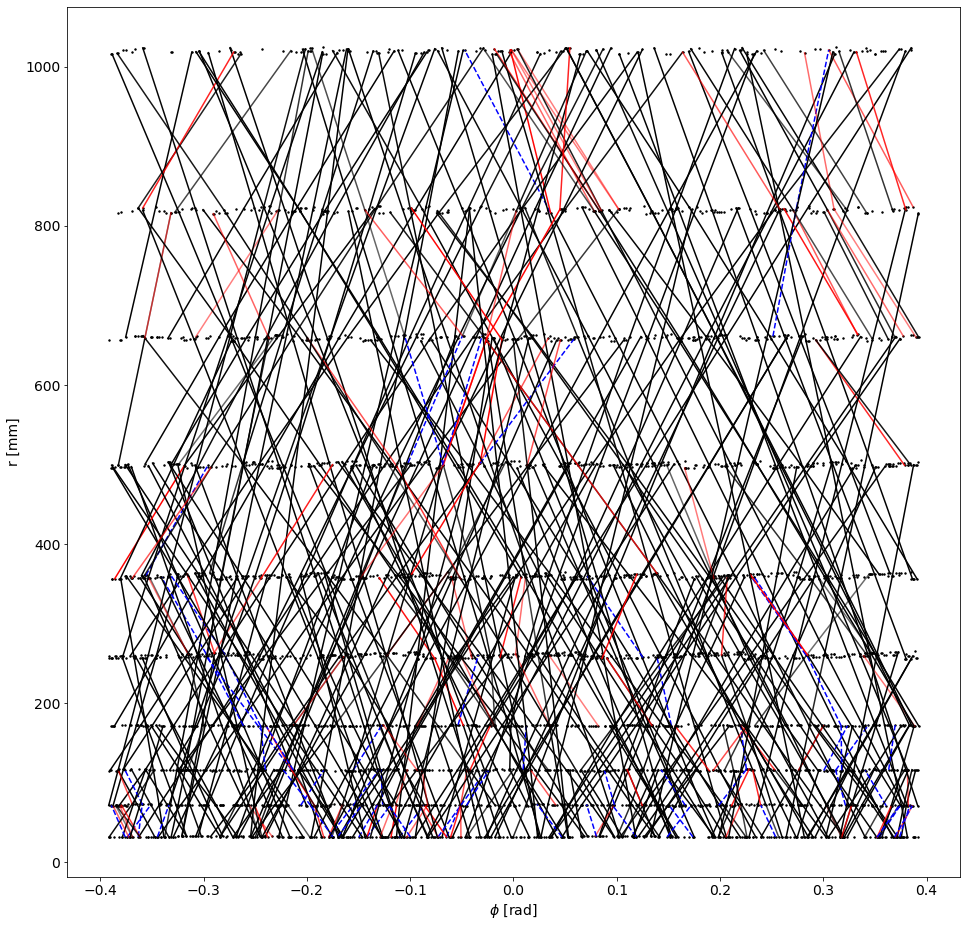

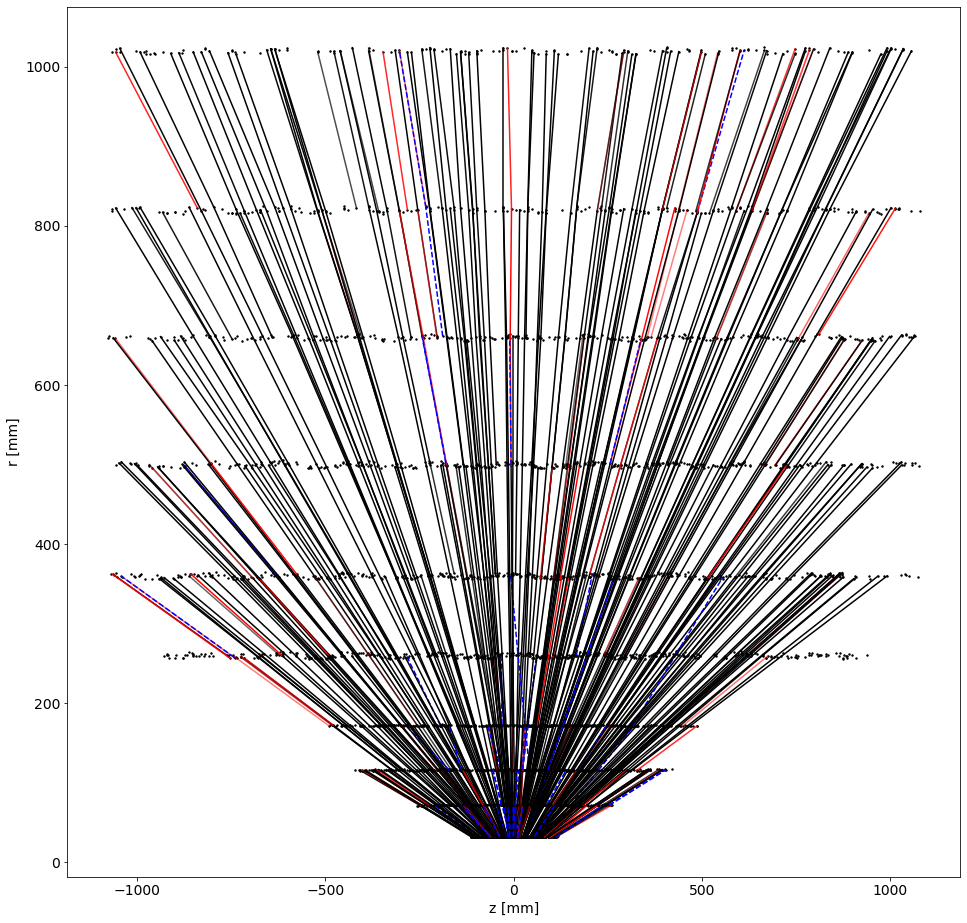

In [19]:
draw_cut = 0.5
draw_sample_xy(x, e, o, y, cut=draw_cut);
draw_sample_rphi(x, e, o, y, cut=draw_cut);
draw_sample_rz(x, e, o, y, cut=draw_cut);